In [5]:
import gymnasium as gym
from agilerl.components.multi_agent_replay_buffer import MultiAgentReplayBuffer
from agilerl.algorithms.ddpg import DDPG
from pettingzoo.sisl import multiwalker_v9
import numpy as np


# Create environment and Experience Replay Buffer
# env = multiwalker_v9.parallel_env(render_mode='human')
env = multiwalker_v9.parallel_env()
env.reset()
try:
    state_dim = [env.observation_space(agent).shape[0] for agent in env.agents]
    one_hot = False
    
except Exception:
    state_dim = [env.observation_space(agent).n for agent in env.agents]
    one_hot = True
# Requires one-hot encoding
try:
    action_dim = [env.action_space(agent).shape[0] for agent in env.agents]
except Exception:
    action_dim = [env.action_space(agent).n for agent in env.agents]

field_names = ["state", "action", "reward", "next_state", "done"]
memory = MultiAgentReplayBuffer(memory_size=300, field_names=field_names, agent_ids=env.agents)   # Create Experience Replay Buffer
agents = {a:DDPG(state_dim=state_dim, action_dim=action_dim[0], one_hot=one_hot) for a in env.agents}   # Create DDPG agents
# for a, agent in agents.items():
#     path = "./models/ONE_DDPG/DDPG5_trained_agent.pt"
#     DDPG.loadCheckpoint(agent,path=path)

reward_evolution = []
rewards = []

for i in range(2000):
    print(i, "th iteration \nrewards : ", np.sum(rewards))
    reward_evolution.append(np.sum(rewards))
    
    state = env.reset()[0]  # Reset environment at start of episode
    rewards = []

    end_bool = False

    while not end_bool:
        actions = {a:agent.getAction(state[a])[0] for a, agent in agents.items()}    # Get next action from agent
        next_state, reward, done, _, _ = env.step(actions)   # Act in environment
        if 'walker_0' in next_state.keys(): 
            end_bool = True if True in done.values() else False
        else :
            next_state = {a:np.empty((31,)) for a in env.agents}
            end_bool = True
        rewards.append(sum(reward.values())/len(reward))
        memory.save2memory(state, actions, reward, next_state, done)
        # advance in env
        state = next_state
        
        # Learn from experience
        if len(memory) >= agents['walker_0'].batch_size:
            experiences = memory.sample(agents['walker_0'].batch_size) # Sample replay buffer
            for a in env.agents:
                exp = [el[a] for el in experiences]
                agents[a].learn(exp)    # Learn according to agent's RL algorithm
env.close()

0 th iteration 
rewards :  0.0
1 th iteration 
rewards :  -105.45269926389058
2 th iteration 
rewards :  -100.63534640272458
3 th iteration 
rewards :  -104.31084203471741
4 th iteration 
rewards :  -105.79314456880093
5 th iteration 
rewards :  -104.67747621734937
6 th iteration 
rewards :  -108.69982825219631
7 th iteration 
rewards :  -106.53374208013217
8 th iteration 
rewards :  -105.02459166944028
9 th iteration 
rewards :  -103.5790323962768
10 th iteration 
rewards :  -98.4806931267182
11 th iteration 
rewards :  -105.8812325100104
12 th iteration 
rewards :  -111.79504696528116
13 th iteration 
rewards :  -114.3599346280098
14 th iteration 
rewards :  -113.03284763296445
15 th iteration 
rewards :  -108.27820623914401
16 th iteration 
rewards :  -117.65763817230861
17 th iteration 
rewards :  -112.82214895884198
18 th iteration 
rewards :  -107.61595850189528
19 th iteration 
rewards :  -106.90413992355268
20 th iteration 
rewards :  -104.00734746456146
21 th iteration 
reward

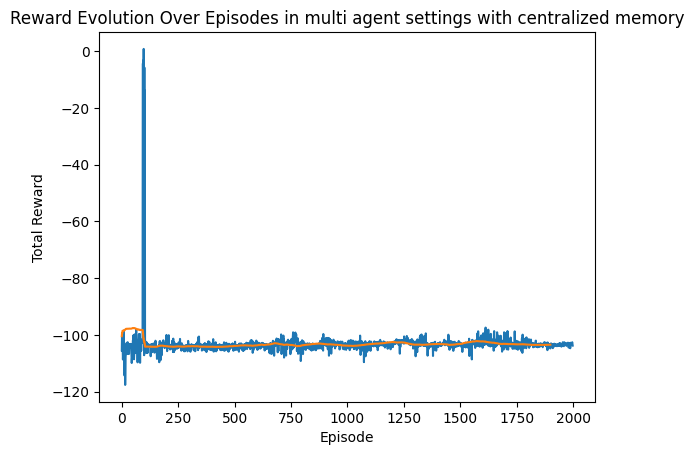

In [7]:

import matplotlib.pyplot as plt

plt.plot(reward_evolution[1:])
plt.xlabel('Episode')
plt.ylabel('Total Reward')
reward_evolution_smoothed = np.convolve(reward_evolution[1:], np.ones(100)/100, mode='valid')
plt.plot(reward_evolution_smoothed)
plt.title('Reward Evolution Over Episodes in multi agent settings with centralized memory')
plt.show()